# Feature extraction

In this notebook we will learn how to extract different features from a text and how to combine them. It's pretty simple, but if you have this part well organized, it will be really useful in the near future. So, let's get started!

In [164]:
import nltk
from sklearn.pipeline import FeatureUnion
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn import preprocessing
from scipy.sparse import coo_matrix, hstack
from copy import deepcopy
import matplotlib.pyplot as plt

In [120]:
from sklearn.preprocessing import LabelEncoder
import os
import glob
import json
import argparse
import time
import codecs
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

In [88]:
import re
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/sallyisa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sallyisa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import os

In [24]:
def open_file(path):
    with open(path, 'r+') as f:
        return '\n'.join([line.strip() for line in f])
    
def process_dir_files(path):
    dir_files = []
    for file in os.listdir(path):
        current = os.path.join(path, file)
        if os.path.isfile(current):
            dir_files.append(open_file(current))
    return dir_files
                     

train_sents= process_dir_files('pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02/problem00001/candidate00001')

In [26]:
from nltk.tokenize import word_tokenize

def get_pos(text):
    pos_tags= nltk.pos_tag(word_tokenize(text))
    # print(len(pos_tags))
    pos_tags = [word_tag[1] for word_tag in pos_tags]
    pos_text = ' '.join(pos_tags)
    return pos_tags

#get_pos(train_sents[0])

In [8]:
def get_pos_ngrams(sents):
    pos_tags= [nltk.pos_tag(word_tokenize(sents[ind])) for ind, item in enumerate(sents) if item != '']
    pos_sents = []
    for sent in pos_tags:
        #print(sent)
        pos = ' '.join([pos_tag[1] for pos_tag in sent])
        #print(pos, '\n')
        pos_sents.append(pos)
    vectorizer = CountVectorizer(ngram_range = (1,1))
    vectorizer.fit(pos_sents)
    return vectorizer


#pos_vectorizer = get_pos_ngrams(train_sents)
#pos_ngram = pos_vectorizer.transform(train_sents)
#pos_ngram

In [45]:
# -*- coding: utf-8 -*-

"""
 A baseline authorship attribution method 
 based on a character n-gram representation
 and a linear SVM classifier.
 It has a reject option to leave documents unattributed
 (when the probabilities of the two most likely training classes are too close)
 
 Questions/comments: stamatatos@aegean.gr

 It can be applied to datasets of PAN-19 cross-domain authorship attribution task
 See details here: http://pan.webis.de/clef19/pan19-web/author-identification.html
 Dependencies:
 - Python 2.7 or 3.6 (we recommend the Anaconda Python distribution)
 - scikit-learn

 Usage from command line: 
    > python pan19-cdaa-baseline.py -i EVALUATION-DIRECTORY -o OUTPUT-DIRECTORY [-n N-GRAM-ORDER] [-ft FREQUENCY-THRESHOLD] [-pt PROBABILITY-THRESHOLD]
 EVALUATION-DIRECTORY (str) is the main folder of a PAN-19 collection of attribution problems
 OUTPUT-DIRECTORY (str) is an existing folder where the predictions are saved in the PAN-19 format
 Optional parameters of the model:
   N-GRAM-ORDER (int) is the length of character n-grams (default=3)
   FREQUENCY-THRESHOLD (int) is the cutoff threshold used to filter out rare n-grams (default=5)
   PROBABILITY-THRESHOLD (float) is the threshold for the reject option assigning test documents to the <UNK> class (default=0.1)
                                 Let P1 and P2 be the two maximum probabilities of training classes for a test document. If P1-P2<pt then the test document is assigned to the <UNK> class.
   
 Example:

     >  python pan19-cdaa-baseline-svm.py -i ".\pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23\" -o ".\a
nswers-trigram\" -n 3
"""

from __future__ import print_function
import os
import glob
import json
import argparse
import time
import codecs
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV

def represent_text(text,n,pos=False):
    # Extracts all character n-grams from  a 'text'
    # if pos is True, extracts POS n-grams
    if n>0:
        if pos is True:
            text = get_pos(text)
            tokens = [' '.join(text[i:i+n]) for i in range(len(text)-n+1)]
            #print(tokens)
        else:
            tokens = [text[i:i+n] for i in range(len(text)-n+1)]
    frequency = defaultdict(int)
    for token in tokens:
        frequency[token] += 1
    return frequency

represent_text(train_sents[0], 2)
#represent_text(train_sents[0], 2, pos=True)
                           

defaultdict(int,
            {'gr': 7,
             'ra': 6,
             'ac': 10,
             'ce': 16,
             'ef': 5,
             'fu': 11,
             'ul': 8,
             'l ': 9,
             ' o': 29,
             'on': 25,
             'ne': 27,
             'es': 13,
             's.': 4,
             '.\n': 18,
             '\n\n': 34,
             '\n"': 9,
             '"O': 1,
             'On': 1,
             'e ': 131,
             ' m': 20,
             'mo': 6,
             'or': 26,
             're': 41,
             'e,': 9,
             ',"': 6,
             '" ': 8,
             ' M': 7,
             'Ma': 11,
             'ar': 27,
             'rv': 11,
             've': 27,
             'el': 28,
             'lo': 22,
             'ou': 44,
             'us': 28,
             's ': 68,
             ' s': 72,
             'sa': 13,
             'ai': 18,
             'id': 12,
             'd,': 13,
             ', ': 42,
             'so': 5,
    

In [27]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(path+os.sep+label+os.sep+'*.txt')
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label))
        f.close()
    return texts

def extract_vocabulary(texts,n,ft,pos=False):
    # Extracts all characer 'n'-grams occurring at least 'ft' times in a set of 'texts'
    occurrences=defaultdict(int) 
    for (text,label) in texts:
        text_occurrences = {}
        if isinstance(n, int):
            for x in range(1,n+1):
                text_occurrences.update(represent_text(text,x,pos=pos))
        else:
            pass
        for ngram in text_occurrences:
            if ngram in occurrences:
                occurrences[ngram]+=text_occurrences[ngram]
            else:
                occurrences[ngram]=text_occurrences[ngram]
    vocabulary=[]
    for i in occurrences.keys():
        if occurrences[i]>=ft:
            vocabulary.append(i)
    return vocabulary


vocab = extract_vocabulary([(x,i) for i, x in enumerate(train_sents)], 2, 5, pos=True)
print(len(vocab))
print(vocab)
vectorizer = CountVectorizer(vocabulary=[x.lower() for  x in vocab])
print([' '.join(get_pos(text)) for text in train_sents])

train_data = vectorizer.fit_transform([' '.join(get_pos(text)) for text in train_sents])
print(vectorizer.get_feature_names())
train_data = train_data.astype(float)
print(train_data.shape)
print(train_data.toarray())

287
['JJ', 'NNS', '.', '``', 'CD', 'JJR', ',', "''", 'NNP', 'VBD', 'VBG', 'RB', 'VBN', 'IN', 'PRP$', 'NN', 'PRP', '(', 'DT', ')', ':', 'VBP', 'TO', 'CC', 'VB', 'WP', 'RP', 'WRB', 'EX', 'VBZ', 'JJS', 'MD', 'PDT', 'WDT', 'JJ NNS', 'NNS .', '. ``', ", ''", "'' NNP", 'NNP VBD', 'VBD ,', ', VBG', 'VBG RB', 'RB VBN', 'VBN IN', 'IN PRP$', 'PRP$ NN', 'NN .', '`` PRP', 'PRP VBD', 'VBD RB', 'VBN ,', ', IN', 'IN RB', 'RB RB', 'RB .', '. (', 'DT NN', 'NN NN', '. PRP', 'RB :', 'PRP$ NNS', 'NNS VBP', 'VBP RB', 'RB IN', 'VBN TO', 'NN IN', 'IN NN', 'NN CC', 'CC PRP$', 'NNS VBD', 'VBD TO', 'TO VB', 'VB PRP$', 'PRP$ JJ', 'JJ .', '. CC', 'CC VBD', 'VBD IN', 'IN PRP', 'VBD VBG', 'VBG TO', 'VB NNP', 'NNP NNP', 'NNP NN', 'NN VBD', 'VBD NN', 'NN TO', 'NN ,', ', CC', 'VB PRP', 'PRP VB', 'VB IN', 'IN DT', 'IN NNP', 'NNP ,', ': IN', 'VBD PRP', 'PRP CC', 'CC RB', 'VBD DT', '. NNP', 'VBD VBN', 'TO DT', 'DT IN', 'PRP ,', ', DT', 'NN WP', 'WP PRP', 'VBD .', '. IN', 'VBD NNP', 'JJ NN', 'NN RB', 'RB CC', 'PRP RP', ',

['jj', 'nns', '.', '``', 'cd', 'jjr', ',', "''", 'nnp', 'vbd', 'vbg', 'rb', 'vbn', 'in', 'prp$', 'nn', 'prp', '(', 'dt', ')', ':', 'vbp', 'to', 'cc', 'vb', 'wp', 'rp', 'wrb', 'ex', 'vbz', 'jjs', 'md', 'pdt', 'wdt', 'jj nns', 'nns .', '. ``', ", ''", "'' nnp", 'nnp vbd', 'vbd ,', ', vbg', 'vbg rb', 'rb vbn', 'vbn in', 'in prp$', 'prp$ nn', 'nn .', '`` prp', 'prp vbd', 'vbd rb', 'vbn ,', ', in', 'in rb', 'rb rb', 'rb .', '. (', 'dt nn', 'nn nn', '. prp', 'rb :', 'prp$ nns', 'nns vbp', 'vbp rb', 'rb in', 'vbn to', 'nn in', 'in nn', 'nn cc', 'cc prp$', 'nns vbd', 'vbd to', 'to vb', 'vb prp$', 'prp$ jj', 'jj .', '. cc', 'cc vbd', 'vbd in', 'in prp', 'vbd vbg', 'vbg to', 'vb nnp', 'nnp nnp', 'nnp nn', 'nn vbd', 'vbd nn', 'nn to', 'nn ,', ', cc', 'vb prp', 'prp vb', 'vb in', 'in dt', 'in nnp', 'nnp ,', ': in', 'vbd prp', 'prp cc', 'cc rb', 'vbd dt', '. nnp', 'vbd vbn', 'to dt', 'dt in', 'prp ,', ', dt', 'nn wp', 'wp prp', 'vbd .', '. in', 'vbd nnp', 'jj nn', 'nn rb', 'rb cc', 'prp rp', ', jj'

In [156]:
class Feature_Extractor():
    '''
    Performs feature extraction on input docs.
    '''
    def __init__(self, n, ft):
        self.n = n
        self.ft = ft
        
    def fit_transform(self, docs):
        ## Char-level n-grams ##
        char_vocab = extract_vocabulary(docs,self.n,self.ft)
        self.char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(self.n,self.n),
                                          lowercase=False, vocabulary=char_vocab
                                              )
        char_data, self.char_vectorizer = self._fit_transform(self.char_vectorizer, docs)
        print(char_data.shape)
        print(char_data.toarray())

        ## POS n-grams ##
        pos_vocab = [x.lower() for x in extract_vocabulary(docs,2,self.ft,pos=True)]
        print(pos_vocab)
        self.pos_vectorizer = CountVectorizer(ngram_range=(1,2), vocabulary=pos_vocab
                                             )
        print('\t', 'pos vocabulary size:', len(pos_vocab), 'char vocabulary size:', len(char_vocab))
        pos_data, self.pos_vectorizer = self._fit_transform(self.pos_vectorizer, docs, pos_replace=True)
        
        ## Word n-grams ##
        self.word_vectorizer = CountVectorizer(ngram_range=(2,3))
        word_data, self.word_vectorizer = self._fit_transform(self.word_vectorizer, docs)
        
        ## Lexical Diversity
        lex_div = self.lexical_diversity(docs)
        print(pos_data.toarray()[:,1])
        print('pos data: %s char data: %s word data: %s'%(pos_data.shape, char_data.shape, word_data.shape))
        feature_data = self.combine_features((lex_div, pos_data, char_data, word_data 
                                             )) 
        return feature_data
    
    def combine_features(self, feat_tuple):
        feature_data = hstack(feat_tuple)
        return feature_data
    
    def replace_words_POS(self, texts):
        return [' '.join(get_pos(text)) for text in texts]
    
    def lexical_diversity(self, docs):
        lex_div = np.array([len(set(text)) / len(text) for (text,label) in docs]).reshape(len(docs), 1)
        print('lexical diversity:', lex_div.shape)
        return lex_div
    
    def _fit_transform(self, vectorizer, docs, pos_replace=False):
        texts = [text for i,(text,label) in enumerate(docs)]
        if pos_replace is True:
            texts = self.replace_words_POS(texts) # replace words in text with POS
        vec_data = vectorizer.fit_transform(texts)
        vec_data = vec_data.astype(float)
        return vec_data, vectorizer
    
    def _transform(self, vectorizer, docs, pos_replace=False):
        texts = [text for i,(text,label) in enumerate(docs)]
        if pos_replace is True:
            texts = self.replace_words_POS(texts) # replace words in text with POS
        vec_data = vectorizer.transform(texts)
        vec_data = vec_data.astype(float)
        return vec_data
    
    def transform(self, docs):
        char_data = self._transform(self.char_vectorizer, docs)
        word_data = self._transform(self.word_vectorizer, docs)
        pos_data = self._transform(self.pos_vectorizer, docs, pos_replace=True)
        lex_div = self.lexical_diversity(docs)
        feature_data = self.combine_features((lex_div, pos_data, char_data, word_data
                                             )) 
        return feature_data
        
    

def baseline(path, outpath, n=3, ft=5, pt=0.1, feature_selection=False, 
             open_set=False, c=1, feat_sel_percent=None, clf=None):
    start_time = time.time()
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    problems = []
    language = []
    with open(infocollection, 'r') as f:
        for attrib in json.load(f):
            problems.append(attrib['problem-name'])
            language.append(attrib['language'])
    for index,problem in enumerate(problems):
        print(problem)
        # Reading information about the problem
        infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
        candidates = []
        with open(infoproblem, 'r') as f:
            fj = json.load(f)
            unk_folder = fj['unknown-folder']
            for attrib in fj['candidate-authors']:
                candidates.append(attrib['author-name'])
        # Building training set
        train_docs=[]
        for candidate in candidates:
            train_docs.extend(read_files(path+os.sep+problem,candidate))
        train_labels = [label for i,(text,label) in enumerate(train_docs)]
        #### Feature Extraction ###
        ###### Fit-Transform Training Set #######
        feat_extractor = Feature_Extractor(n, ft)
        train_data = feat_extractor.fit_transform(train_docs)
        if feature_selection is True:
            ####### Feature Selection - Fit #######
            print("training before feature selection:", train_data.shape)
            #sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
            #train_data = sel.fit_transform(train_data)
            # We use the default selection function: the 10% most significant features
            sel = SelectPercentile(f_classif, percentile=feat_sel_percent)
            train_data = sel.fit_transform(train_data, train_labels)
            #sel = SelectKBest(chi2, k=100000)
            #train_data = sel.fit_transform(train_data, train_labels)
            print("training after feature selection:", train_data.shape)
        print('\t', 'language: ', language[index])
        print('\t', len(candidates), 'candidate authors')
        print('\t', len(train_docs), 'known texts')
        
        ###### Transform Test Set #######
        test_docs=read_files(path+os.sep+problem,unk_folder)
        test_data = feat_extractor.transform(test_docs)
        if feature_selection is True:
            ####### Feature Selection #######
            print("test before feature selection:", test_data.shape)
            test_data = sel.transform(test_data)
            print("test after feature selection:", test_data.shape)
        print('\t', len(test_docs), 'unknown texts')
        
        ###### Applying Classifiers #####
        max_abs_scaler = preprocessing.MaxAbsScaler()
        scaled_train_data = max_abs_scaler.fit_transform(train_data)
        scaled_test_data = max_abs_scaler.transform(test_data)
        clf=CalibratedClassifierCV(OneVsRestClassifier(SVC(C=c)))
        clf.fit(scaled_train_data, train_labels)
        predictions=clf.predict(scaled_test_data)
        proba=clf.predict_proba(scaled_test_data)
        if open_set is True:
            # Reject option (used in open-set cases)
            count=0
            for i,p in enumerate(predictions):
                sproba=sorted(proba[i],reverse=True)
                if sproba[0]-sproba[1]<pt:
                    predictions[i]=u'<UNK>'
                    count=count+1
            print('\t',count,'texts left unattributed')
        # Saving output data
        out_data=[]
        unk_filelist = glob.glob(path+os.sep+problem+os.sep+unk_folder+os.sep+'*.txt')
        pathlen=len(path+os.sep+problem+os.sep+unk_folder+os.sep)
        for i,v in enumerate(predictions):
            out_data.append({'unknown-text': unk_filelist[i][pathlen:], 'predicted-author': v})
        with open(outpath+os.sep+'answers-'+problem+'.json', 'w') as f:
            json.dump(out_data, f, indent=4)
        print('\t', 'answers saved to file','answers-'+problem+'.json')
    print('elapsed time:', time.time() - start_time)

base_dir='pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02'
out_dir = base_dir+os.sep+'output-dir'
eval_dir = base_dir+os.sep+'eval-dir'

params = {'n': 5,'ft': 3,'pt': 0.05,'feature_selection': True, 'c':0.1, 'feat_sel_percent': 85, 'clf': 'SVC'}
params = {'n': 5,'ft': 3,'pt': 0.05,'feature_selection': False, 'c':0.1, 'feat_sel_percent': None, 'clf': 'SVC'}
params = {'n': 5,'ft': 3,'pt': 0.05,'feature_selection': True, 'c':1, 'feat_sel_percent': 85, 'clf': 'SVC'}
baseline(base_dir,out_dir,**params)
%timeit

problem00001
(140, 64239)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 3. 3. 4.]]
['jj', 'nns', '.', '``', 'cd', 'jjr', ',', "''", 'nnp', 'vbd', 'vbg', 'rb', 'vbn', 'in', 'prp$', 'nn', 'prp', '(', 'dt', ')', ':', 'vbp', 'to', 'cc', 'vb', 'wp', 'rp', 'wrb', 'ex', 'vbz', 'jjs', 'md', 'pdt', 'uh', 'wdt', 'jj nns', 'nns .', '. ``', '`` cd', 'cd jjr', 'jjr ,', ", ''", "'' nnp", 'nnp vbd', 'vbd ,', ', vbg', 'vbg rb', 'rb vbn', 'vbn in', 'in prp$', 'prp$ nn', 'nn .', '`` prp', 'prp vbd', 'vbd rb', 'vbn ,', ', in', 'in rb', 'rb rb', 'rb .', '. (', '( dt', 'dt nn', 'nn nn', 'nn )', ') .', '. prp', 'rb :', ': prp$', 'prp$ nns', 'nns vbp', 'vbp rb', 'rb in', 'in vbn', 'vbn to', 'to nn', 'nn in', 'in nn', 'nn cc', 'cc prp$', 'nns vbd', 'vbd to', 'to vb', 'vb prp$', 'prp$ jj', 'jj .', '. cc', 'cc vbd', 'vbd in', 'in prp', 'vbd vbg', 'vbg to', 'vb nnp', 'nnp nnp', 'nnp nn', 'nn vbd', 'vbd nn', 'nn to'

lexical diversity: (140, 1)
[20. 27. 27. 35. 20. 13. 17. 27. 27. 13. 30. 33. 34. 27. 29. 29. 17. 42.
 23. 22. 38. 34. 43. 25. 16. 22. 19. 29. 36. 25. 39. 24. 30. 39. 49. 21.
 21. 32. 23. 34. 22. 35. 15. 19.  7. 30. 18. 14. 18. 32. 20. 22. 16. 31.
 23. 10. 16. 43. 23. 12. 23. 28. 31. 20. 34. 40. 35. 30. 15. 19. 34. 25.
 34. 32. 18. 24. 27. 21. 17. 25. 39. 19. 27. 29. 11. 27. 12. 19. 22. 18.
 14. 11. 21. 37. 25. 19. 30. 32. 30.  9. 22. 28. 19. 35. 19. 29. 12. 18.
 29. 16. 25. 16. 17. 31. 28. 24. 18. 30. 24. 26. 33. 31. 38. 26. 27. 39.
 24. 32. 28. 42. 15. 34. 22. 23. 27. 27. 36. 32. 24. 36.]
pos data: (140, 861) char data: (140, 64239) word data: (140, 158555)
training before feature selection: (140, 223656)


/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


training after feature selection: (140, 190107)
	 language:  en
	 20 candidate authors
	 140 known texts
lexical diversity: (105, 1)
test before feature selection: (105, 223656)
test after feature selection: (105, 190107)
	 105 unknown texts


/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:19

	 answers saved to file answers-problem00001.json
problem00002
(35, 26761)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 3. 3. 3.]]
['dt', 'nn', '.', "''", 'nnp', 'rb', 'vbz', 'in', ',', 'jj', '``', 'prp', 'md', 'vb', 'to', 'vbg', 'rp', 'prp$', 'vbd', 'wp', 'nns', 'vbp', 'cc', 'vbn', 'cd', ':', 'pos', 'wrb', 'jjs', 'uh', 'rbs', 'pdt', 'dt nn', 'nn .', ". ''", "'' nnp", 'nnp rb', 'rb vbz', 'vbz dt', '. in', 'in nnp', 'nnp ,', ', dt', 'nn in', 'in dt', 'dt vbz', 'vbz jj', 'jj .', '. ``', '`` in', 'in prp', 'prp md', 'md rb', 'rb vb', 'vb to', 'to prp', 'prp .', '. rb', 'rb ,', ", ''", 'nnp vbz', 'vbz ,', ', vbg', 'vbg rp', 'rp prp$', 'prp$ nn', 'nn ,', 'dt jj', 'jj nn', 'in nn', '. nnp', 'nnp vbd', 'vbd prp', 'prp rb', 'rb .', '`` wp', 'wp vbz', 'vbz prp', 'vbz prp$', 'prp$ nns', 'nns rb', 'vbg .', '`` prp', 'prp vbz', ', nn', '. wp', 'prp vb', 'vb in', 'in .', "'' prp", 'nn rp', 'rp rb', '

/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


lexical diversity: (21, 1)
test before feature selection: (21, 71885)
test after feature selection: (21, 56848)
	 21 unknown texts


/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/sallyisa/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:19

	 answers saved to file answers-problem00002.json
elapsed time: 64.04082322120667


In [157]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
# Evaluation script for the Cross-Domain Authorship Attribution task @PAN2019.
We use the F1 metric (macro-average) as implemented in scikit-learn:
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
We include the following ad hoc rules:
- If authors are predicted which were not seen during training,
  these predictions will count as false predictions ('<UNK>' class)
  and they will negatively effect performance.
- If texts are left unattributed they will assigned to the ('<UNK>'
  class) and they will negatively effect performance.
- The <UNK> class is excluded from the macro-average across classes.
- If multiple test attributions are given for a single unknown document,
  only the first one will be taken into consideration.

Dependencies:
- Python 2.7 or 3.6 (we recommend the Anaconda Python distribution)
- scikit-learn

Usage from the command line:
>>> python pan19-cdaa-evaluator.py -i COLLECTION -a ANSWERS -o OUTPUT
where
    COLLECTION is the path to the main folder of the evaluation collection
    ANSWERS is the path to the answers folder of a submitted method
    OUTPUT is the path to the folder where the results of the evaluation will be saved

Example: 
>>>  python pan19-cdaa-evaluator.py -i ".\pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23\" -a ".\answ
ers-unigram" -o ".\eval-unigram\"

# References:
@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}
"""

import argparse
import os
import json
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        labels=list(set(gold_author_ints))
        # Exclude the <UNK> class
        for x in labels:
            if encoder.inverse_transform(np.array([x]))=='<UNK>':
                labels.remove(x)
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels,
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels,
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels,
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall

def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall =  eval_measures(gt,pred)
    return round(f1,3), round(precision,3), round(recall,3)

def evaluate_all(path_collection,path_answers,path_out,params):
    # Calculates evaluation measures for a PAN-18 collection of attribution problems
    infocollection = path_collection+os.sep+'collection-info.json'
    problems = []
    data = []
    with open(infocollection, 'r') as f:
        for attrib in json.load(f):
            problems.append(attrib['problem-name'])
    scores=[];
    for problem in problems:
        prob_data = deepcopy(params)
        f1,precision,recall=evaluate(path_collection+os.sep+problem+os.sep+'ground-truth.json',path_answers+os.sep+'answers-'+problem+'.json')
        scores.append(f1)
        prob_data.update({'problem-name': problem, 'macro-f1': round(f1,3), 'macro-precision': round(precision,3), 'macro-recall': round(recall,3)})
        if os.path.isfile('metrics.csv'):
            with open('metrics.csv', 'a') as f:  # Just use 'w' mode in 3.x
                w = csv.DictWriter(f, prob_data.keys())
                w.writerow(prob_data)
        else:
            with open('metrics.csv', 'w') as f:  # Just use 'w' mode in 3.x
                w = csv.DictWriter(f, prob_data.keys())
                w.writeheader()
                w.writerow(prob_data)
        data.append(prob_data)
        print(str(problem),'Macro-F1:',round(f1,3))
    overall_score=sum(scores)/len(scores)
    # Saving data to output files (out.json and evaluation.prototext)
    with open(path_out+os.sep+'out.json', 'w') as f:
        json.dump({'problems': data, 'overall_score': round(overall_score,3)}, f, indent=4, sort_keys=True)
    print('Overall score:', round(overall_score,3))
    prototext='measure {\n key: "mean macro-f1"\n value: "'+str(round(overall_score,3))+'"\n}\n'
    with open(path_out+os.sep+'evaluation.prototext', 'w') as f:
        f.write(prototext)
    return pd.read_csv('metrics.csv')
        
params
evaluate_all(base_dir,out_dir,eval_dir, params)


problem00001 Macro-F1: 0.572
problem00002 Macro-F1: 0.783
Overall score: 0.678


,n,ft,pt,feature_selection,c,feat_sel_percent,clf,problem-name,macro-f1,macro-precision,macro-recall
0,5,3,0.05,True,0.1,85.0,SVC,problem00001,0.641,0.621,0.784
1,5,3,0.05,True,0.1,85.0,SVC,problem00002,0.783,0.783,0.783
2,5,3,0.05,False,0.1,NaN,SVC,problem00001,0.532,0.496,0.689
3,5,3,0.05,False,0.1,NaN,SVC,problem00002,0.783,0.783,0.783
4,5,3,0.05,True,1.0,85.0,SVC,problem00001,0.572,0.583,0.686
5,5,3,0.05,True,1.0,85.0,SVC,problem00002,0.783,0.783,0.783


In [187]:
df = pd.read_csv('metrics.csv')
df

,n,ft,pt,feature_selection,c,feat_sel_percent,clf,problem-name,macro-f1,macro-precision,macro-recall
0,5,3,0.05,True,0.1,85.0,SVC,problem00001,0.641,0.621,0.784
1,5,3,0.05,True,0.1,85.0,SVC,problem00002,0.783,0.783,0.783
2,5,3,0.05,False,0.1,NaN,SVC,problem00001,0.532,0.496,0.689
3,5,3,0.05,False,0.1,NaN,SVC,problem00002,0.783,0.783,0.783
4,5,3,0.05,True,1.0,85.0,SVC,problem00001,0.572,0.583,0.686
5,5,3,0.05,True,1.0,85.0,SVC,problem00002,0.783,0.783,0.783


In [190]:
df.set_index('c', inplace=True)
df

,n,ft,pt,feature_selection,feat_sel_percent,clf,problem-name,macro-f1,macro-precision,macro-recall
c,,,,,,,,,,
0.1,5,3,0.05,True,85.0,SVC,problem00001,0.641,0.621,0.784
0.1,5,3,0.05,True,85.0,SVC,problem00002,0.783,0.783,0.783
0.1,5,3,0.05,False,NaN,SVC,problem00001,0.532,0.496,0.689
0.1,5,3,0.05,False,NaN,SVC,problem00002,0.783,0.783,0.783
1.0,5,3,0.05,True,85.0,SVC,problem00001,0.572,0.583,0.686
1.0,5,3,0.05,True,85.0,SVC,problem00002,0.783,0.783,0.783


problem-name
problem00001    AxesSubplot(0.125,0.125;0.775x0.755)
problem00002    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

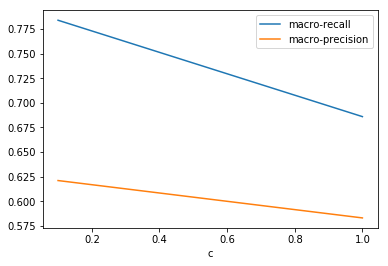

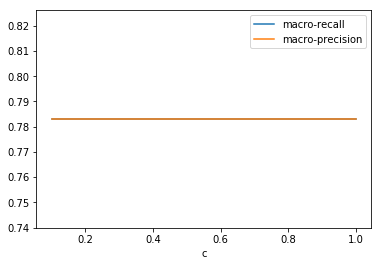

In [193]:
df[df['feature_selection'] == True].groupby(['problem-name'])['macro-recall', 'macro-precision'].plot(legend=True)

In [145]:
import csv

my_dict = {"test": 1, "testing": 2}

with open('mycsvfile.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, my_dict.keys())
    w.writeheader()
    w.writerow(my_dict)

### Exercise 5: Combine all features for each sentence.

Combine all the previous features, and generate a matrix encoding all previously mentioned features: unigrams, bigrams, trigrams and pos_tags. The resulting matrix should have the following dimensions: 3x31

You could use the `sklearn.pipeline.FeatureUnion` class.

In [ ]:
#toks = sentence_tokenize(train_sentences)

pipe2 = Pipeline (FeatureUnion([("uni", CountVectorizer(ngram_range = (1,3), min_df = 1)),("PoS", nltk.word_tokenize(train_sentences_1[0]))])


#CountVectorizer(ngram_range = (1,1), min_df = 1) #token_pattern=u"(?u)\\b\\w+\\b"

#bigrams_bow = bigr.fit_transform(train_sentences)
#union.fit_transform(train_sentences)    


### Extra to play with: Check this website and think about it. Do you think you can use this for something? (in the exam)

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

## SHARE YOUR KNOWLEDGE!

### Do you know any other way of representing the features of the training/testing set?

Please share your knowledge using the forum from Absalon!!!